In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['pdf.fonttype'] = 42
%cd /rna/han/gigyf2_nsp2/exp_data/fclip_seq

/rna/han/gigyf2_nsp2/exp_data/fclip_seq


In [12]:
direc = "/rna/han/gigyf2_nsp2/exp_data/fclip_seq/"
## normalization
samples = []
counts = []
with open(direc + "bam_count.txt",'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    for i in range(len(lines)):
        if i % 2 == 0:
            samples.append(lines[i])
        else:
            counts.append(lines[i])
            
counts = {samples[i].split(".")[0].replace("anti", ""):int(counts[i]) for i in range(len(samples))}

def readcoverage_hd(name):
    if name in ["gigyf2_1", "gigyf2_2"]:
        fname = "anti" + name
    else:
        fname = name
    return np.genfromtxt(direc + "hd_uniq/coverage_files/infected_%s.sars_cov_2.coverage.txt"%fname, dtype=int)[:,2]/counts[name] * 10**6

def addarray(a,b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

hg1, hg2 = readcoverage_hd("gigyf2_1"), readcoverage_hd("gigyf2_2")
hi1, hi2 = readcoverage_hd("igg_1"), readcoverage_hd("igg_2")
hg, hi = addarray(hg1, hg2), addarray(hi1, hi2)

In [13]:
annoutr = pd.read_csv("~/reference/cov2/sars_cov_2_annotation_colors.csv")
annoutr["name"] = annoutr["name"].str.capitalize().replace("utr","UTR")
annoutr["name"] = annoutr["name"].str.replace("utr","UTR")
annoutr.loc[annoutr["name"] == "Orf7b", "color"] = "MediumPurple"

def pre(name):
    d = pd.read_table(name)
    if "summary" in name:
        d = d[d["is_reproducible"] == True]
    d["adj_pval"] = d["adj_pval"].apply(lambda x: max(float(f) for f in x.split(";")))
    d = d[d.chrom == "NC_045512.2"]
    d = d[['chrom', 'start', 'end', 'name', 'region', "adj_pval"]]
    return d

d = pre("/rna/han/gigyf2_nsp2/exp_data/fclip_seq/hd_uniq/piranha_files/infected_antigigyf2.window_50.bed.summary.count.txt")
gcovs1, gcovs2, icovs1, icovs2 = [], [], [], []
for _, row in d.iterrows():
    start, end = row['start'], row['end']
    gcovs1.append(sum(hg1[start:end]))
    gcovs2.append(sum(hg2[start:end]))
    icovs1.append(sum(hi1[start:end]))
    icovs2.append(sum(hi2[start:end]))

d['gigyf2_1'] = gcovs1
d['gigyf2_2'] = gcovs2
d['igg_1'] = icovs1
d['igg_2'] = icovs2
d["logfc_1"] = np.log2(d['gigyf2_1'] / d['igg_1'])
d["logfc_2"] = np.log2(d['gigyf2_2'] / d['igg_2'])
d["logfc"] = (d["logfc_1"] + d["logfc_2"]) / 2
d["enrichment"] = np.sqrt((d["gigyf2_1"] * d["gigyf2_2"]) / (d["igg_1"] * d["igg_2"]))
d = d.sort_values('enrichment', ascending=False)
peaks = []
newd = []
for i, row in d.iterrows():
    start, end = row['start'], row['end']
    for peak in peaks:
        peakstart, peakend = peak[0], peak[1]
        if (start >= peakstart and start <= peakend) or (end >= peakstart and end <= peakend) or (start <= peakstart and end >= peakend):
            break
    else:
        peaks.append((start, end))
        newd.append(row)
d = pd.DataFrame(newd)
d.loc[d.start == 5250, "name"] = "Nsp3"
d.loc[d.start == 14800, "name"] = "Nsp12"
d["name"] = d["name"].str.capitalize()
d["name"] = d["name"].str.replace("utr", "' UTR")

hd = d[d["adj_pval"] < 0.001]
hd = hd[hd["enrichment"] > 1.9]
hd = hd.drop_duplicates("start", keep = "first").reset_index(drop=True)
# hd.to_csv("/rna/han/gigyf2_nsp2/exp_data/fclip_seq/processed/hd_piranha_coverage_fdr_001_enrichment_1_9.txt", sep="\t", index=False)
hd

,chrom,start,end,name,region,adj_pval,gigyf2_1,gigyf2_2,igg_1,igg_2,logfc_1,logfc_2,logfc,enrichment
0,NC_045512.2,5250,5300,Nsp3,CDS,0.000076,4970.094235,5390.800325,826.086260,1312.251286,2.588909,2.038455,2.313682,4.971503
1,NC_045512.2,0,50,5' UTR,5UTR,0.000401,15788.045252,14468.710617,3747.255485,6942.652225,2.074926,1.059378,1.567152,2.963192
2,NC_045512.2,26650,26700,M,CDS,0.000882,7049.240589,7598.256481,2117.665571,3001.215471,1.734993,1.340122,1.537557,2.903026
3,NC_045512.2,27250,27300,Orf6,CDS,0.000190,19248.937581,14918.471370,7772.786941,6499.338151,1.308275,1.198735,1.253505,2.384200
4,NC_045512.2,26550,26600,M,CDS,0.000020,17383.820998,14841.261035,6072.535327,10627.570389,1.517374,0.481802,0.999588,1.999429


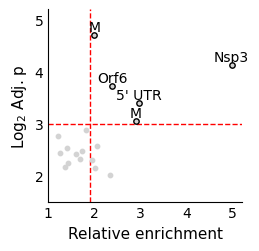

In [14]:
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.left'] = True
fig, ax = plt.subplots(figsize=(2.5, 2.5))
data = d.copy()
data["logp"] = -np.log10(data["adj_pval"])
candi = data[(data["adj_pval"] < 0.001) & (data["enrichment"] > 1.9)]
no = data[(data["adj_pval"] >= 0.001) | (data["enrichment"] <= 1.9)]
ax.scatter(candi["enrichment"], candi["logp"], s=15, color="lightgrey", edgecolor='k', zorder=4)
ax.scatter(no["enrichment"], no["logp"], s=10, color="lightgrey", zorder=3)
for i, row in candi.iterrows():
    ax.text(row["enrichment"], row["logp"] + .02, row["name"], fontsize=10, ha="center", va="bottom")
ax.axhline(-np.log10(0.001), color="r", ls="--", lw = 1, zorder=2)
ax.axvline(1.9, color="r", ls="--", lw = 1, zorder=2)
ax.set_xlim(1, 5.2)
ax.set_ylim(1.5, 5.2)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=45, ha="right")
ax.set_xlabel("Relative enrichment", fontsize=11)
ax.set_ylabel(r"Log$_2$ Adj. p", fontsize=11)
ax.set_xticks(range(1, 6, 1))
ax.set_yticks(range(2, 6, 1))
ax.tick_params(length=0)
# ax.set_yticklabels(range(1, 6, 2), minor=True, fontsize=10)
# ax.grid(lw=1, ls='-', zorder=1)
# ax.grid(axis="y", lw=0.5, ls='-', zorder=1, which="minor")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

name = "peak"
# plt.savefig("/rna/han/gigyf2_nsp2/exp_data/fclip_seq/pdf/others/volcano_%s.pdf"%name, bbox_inches='tight')

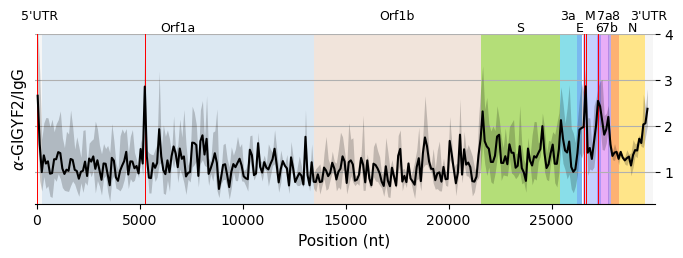

In [8]:
def plot_peak_cov2_average(ax, cov, g1, g2, i1, i2, leftlim, rightlim, miny, maxy, window, shift, ylabel):
    mpl.rcParams['ytick.labelright'] = True
    mpl.rcParams['ytick.labelleft'] = False
    mpl.rcParams['ytick.right'] = True
    mpl.rcParams['ytick.left'] = False
    newg1=np.array([])
    newg2=np.array([])
    newi1=np.array([])
    newi2=np.array([])
    xaxis=[]
    for i in range((len(g1)-window)//shift):
        if shift*i<leftlim:
            continue
        if shift*i+window>rightlim:
            continue
        xaxis.append(shift*i+window/2)
        newg1 = np.append(newg1, np.mean(g1[i*shift:i*shift+window]))
        newg2 = np.append(newg2, np.mean(g2[i*shift:i*shift+window]))
        newi1 = np.append(newi1, np.mean(i1[i*shift:i*shift+window]))
        newi2 = np.append(newi2, np.mean(i2[i*shift:i*shift+window]))
    new1 = np.log2(newg1/newi1)
    new2 = np.log2(newg2/newi2)
    new = (new1 + new2) / 2
    std = np.array([np.std([a, b]) for a, b in zip(new1, new2)])
    ax.plot(xaxis, 2**new, c='black', lw=1.5, zorder=5)
    ax.fill_between(xaxis, 2**(new-std), 2**(new+std), color='black', alpha=0.2, linewidth=0, zorder=3)
    ax.set_xlim(leftlim-100, rightlim+100)
    ax.set_ylim(miny, maxy)
    ax.set_xlabel("Position (nt)", fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.tick_params(labelsize=10)
    ax.grid(True, zorder = 2)
    
    for i, row in annoutr.iterrows():
        start,end=row['start'],row['end']
        name=row['name'].replace("Orf3a","3a").replace('Orf6', '6').replace("Orf8","8").replace("Orf7a","7a").replace("Orf7b","7b")
        ax.axvspan(start, end, fc=row['color'], alpha=.6, zorder=1)
        y = maxy + (maxy-miny) * 0.07 * ((i+1)%2)
        ax.text((start+end)/2, y, name, fontsize=9, ha='center', va='bottom')
        
    for _, row in cov.iterrows():
        ax.axvspan(row['start'], row['end'], fc='red', alpha=1, zorder=4)
    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)
    
    plt.setp(ax.get_xgridlines(), visible=False)
    return new.tolist()
w, s = 100, 100
leftlim, rightlim = 0, len(hi)
fig, ax = plt.subplots(1, 1, figsize=(8, 2.2))
enrich = plot_peak_cov2_average(ax, hd, hg1, hg2, hi1, hi2, leftlim, rightlim, .3, 4,  w, s, r'$\alpha$-GIGYF2/IgG')
name = "haedong_uniq_average_with_std"
# plt.savefig('/rna/han/gigyf2_nsp2/exp_data/fclip_seq/png/peak/sars_cov_2_peak_igg_%s.png'%name,dpi=300,bbox_inches = 'tight')
# plt.savefig('/rna/han/gigyf2_nsp2/exp_data/fclip_seq/pdf/peak/sars_cov_2_peak_igg_%s.pdf'%name,bbox_inches = 'tight')

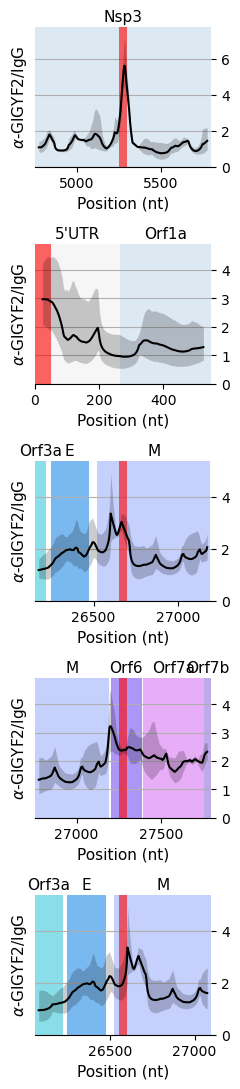

In [9]:
def peak(ax, g1, g2, i1, i2, peakstart, peakend, offset, window, shift):
    if peakstart < offset:
        leftlim = peakstart
    else:
        leftlim = peakstart - offset
    if peakend > min(len(g1), len(g2), len(i1), len(i2)) - offset:
        rightlim = min(peakend, len(g1), len(g2), len(i1), len(i2))
    else:
        rightlim = peakend + offset
    newg1=np.array([])
    newg2=np.array([])
    newi1=np.array([])
    newi2=np.array([])
    xaxis=[]
    for i in range((len(g1)-window)//shift):
        if shift*i<leftlim:
            continue
        if shift*i+window>rightlim:
            continue
        xaxis.append(shift*i+window/2)
        newg1 = np.append(newg1, np.mean(g1[i*shift:i*shift+window]))
        newg2 = np.append(newg2, np.mean(g2[i*shift:i*shift+window]))
        newi1 = np.append(newi1, np.mean(i1[i*shift:i*shift+window]))
        newi2 = np.append(newi2, np.mean(i2[i*shift:i*shift+window]))
    new1 = np.log2(newg1/newi1)
    new2 = np.log2(newg2/newi2)
    new = (new1 + new2) / 2
    std = np.array([np.std([a, b]) for a, b in zip(new1, new2)])
    ax.plot(xaxis, 2**new, c='black', lw=1.5, zorder=4)
    ax.fill_between(xaxis, 2**(new-std), 2**(new+std), color='black', alpha=0.2, linewidth=0, zorder=3)
    return new, leftlim, rightlim, max(2**(new+std))

def annotate(ax, leftlim, rightlim, maxy):
    for _, row in annoutr.iterrows():
        start,end=row['start'],row['end']
        if (start > leftlim) & (end < rightlim):
            ax.axvspan(start, end, fc=row['color'], alpha=.6, zorder=1)
            ax.text((start + end)/2, maxy*1.12, row['name'], fontsize=11, ha='center', va='bottom')
        elif (start<leftlim)&(end>rightlim):
            ax.axvspan(start, end, fc = row['color'], alpha=.6, zorder=1)
            ax.text((leftlim+rightlim)/2, maxy*1.12, row['name'].replace("Orf1a", "Nsp3"), fontsize=11, ha='center', va='bottom')
        elif (start>leftlim)&(start<rightlim)&(end>rightlim):
            ax.axvspan(start, end, fc = row['color'], alpha=.6, zorder=1)
            ax.text((start+rightlim)/2, maxy*1.12, row['name'], fontsize=11, ha='center', va='bottom')
        elif (start<leftlim)&(end>leftlim)&(end<rightlim):
            ax.axvspan(start, end, fc = row['color'], alpha=.6, zorder=1)
            ax.text((leftlim+end)/2, maxy*1.12, row['name'], fontsize=11, ha='center', va='bottom')
    
def plot_peak_cov2_individual(cov, g1, g2, i1, i2, offset, window, shift, ylabel, name = None):
    mpl.rcParams['ytick.labelright'] = True
    mpl.rcParams['ytick.labelleft'] = False
    mpl.rcParams['ytick.right'] = True
    mpl.rcParams['ytick.left'] = False
    n = len(cov)
    fig, axes = plt.subplots(n, 1, figsize=(2.5, 2.2*n))
    for i in range(n):
        peakstart, peakend = cov['start'][i], cov['end'][i]
        ax = axes[i]
        axes[i].axvspan(peakstart, peakend, fc='red', alpha=.6, zorder=2, label = 'Peak')
        new, leftlim, rightlim, maxy = peak(ax, g1, g2, i1, i2, peakstart, peakend, offset, window, shift)
        annotate(ax, leftlim, rightlim, maxy)
        for spside in 'top left right'.split():
            plt.setp(ax.spines[spside], visible=False)
        ax.set_xlim(leftlim, rightlim)
        ax.set_ylim(0, maxy * 1.1)
        ax.set_xlabel("Position (nt)",fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.tick_params(labelsize=10)
        ax.grid(axis= "y", zorder = 2)
    plt.tight_layout()
    
    if name is not None:
        plt.savefig('png/peak/sars_cov_2_peak_individual_%s.png'%name, dpi=300, bbox_inches = 'tight')
        plt.savefig('pdf/peak/sars_cov_2_peak_individual_%s.pdf'%name, bbox_inches = 'tight')
lim = len(hi1)
plot_peak_cov2_individual(hd, hg1, hg2, hi1, hi2, 500, 50, 1, r'$\alpha$-GIGYF2/IgG')#, "haedong_uniq_with_std")

26650 26700
26550 26600


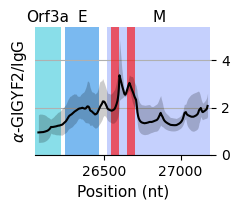

In [10]:
def peak(ax, g1, g2, i1, i2, start, end, offset, window, shift):
    if start < offset:
        leftlim = start
    else:
        leftlim = start - offset
    if end > min(len(g1), len(g2), len(i1), len(i2)) - offset:
        rightlim = min(end, len(g1), len(g2), len(i1), len(i2))
    else:
        rightlim = end + offset
    newg1=np.array([])
    newg2=np.array([])
    newi1=np.array([])
    newi2=np.array([])
    xaxis=[]
    for i in range((len(g1)-window)//shift):
        if shift*i<leftlim:
            continue
        if shift*i+window>rightlim:
            continue
        xaxis.append(shift*i+window/2)
        newg1 = np.append(newg1, np.mean(g1[i*shift:i*shift+window]))
        newg2 = np.append(newg2, np.mean(g2[i*shift:i*shift+window]))
        newi1 = np.append(newi1, np.mean(i1[i*shift:i*shift+window]))
        newi2 = np.append(newi2, np.mean(i2[i*shift:i*shift+window]))
    new1 = np.log2(newg1/newi1)
    new2 = np.log2(newg2/newi2)
    new = (new1 + new2) / 2
    std = np.array([np.std([a, b]) for a, b in zip(new1, new2)])
    ax.plot(xaxis, 2**new, c='black', lw=1.5, zorder=4)
    ax.fill_between(xaxis, 2**(new-std), 2**(new+std), color='black', alpha=0.2, linewidth=0, zorder=3)
    return new, leftlim, rightlim, max(2**(new+std))

def annotate(ax, leftlim, rightlim, maxy):
    for _, row in annoutr.iterrows():
        start,end=row['start'],row['end']
        if (start > leftlim) & (end < rightlim):
            ax.axvspan(start, end, fc=row['color'], alpha=.6, zorder=1)
            ax.text((start + end)/2, maxy*1.12, row['name'], fontsize=11, ha='center', va='bottom')
        elif (start<leftlim)&(end>rightlim):
            ax.axvspan(start, end, fc = row['color'], alpha=.6, zorder=1)
            ax.text((leftlim+rightlim)/2, maxy*1.12, row['name'].replace("Orf1a", "Nsp3"), fontsize=11, ha='center', va='bottom')
        elif (start>leftlim)&(start<rightlim)&(end>rightlim):
            ax.axvspan(start, end, fc = row['color'], alpha=.6, zorder=1)
            ax.text((start+rightlim)/2, maxy*1.12, row['name'], fontsize=11, ha='center', va='bottom')
        elif (start<leftlim)&(end>leftlim)&(end<rightlim):
            ax.axvspan(start, end, fc = row['color'], alpha=.6, zorder=1)
            ax.text((leftlim+end)/2, maxy*1.12, row['name'], fontsize=11, ha='center', va='bottom')
    
def plot_peak_cov2_m(cov, gene, g1, g2, i1, i2, offset, window, shift, ylabel, name = None):
    mpl.rcParams['ytick.labelright'] = True
    mpl.rcParams['ytick.labelleft'] = False
    mpl.rcParams['ytick.right'] = True
    mpl.rcParams['ytick.left'] = False
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.2))
    d = cov[cov['name'] == gene].reset_index(drop=True)
    start, end = min(d['start']), max(d['end'])
    new, leftlim, rightlim, maxy = peak(ax, g1, g2, i1, i2, start, end, offset, window, shift)
    for i in range(len(d)):
        # print(i)
        peakstart, peakend = d['start'][i], d['end'][i]
        print(peakstart, peakend)
        ax.axvspan(peakstart, peakend, fc='red', alpha=.6, zorder=2, label = 'Peak')
    annotate(ax, leftlim, rightlim, maxy)
    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(0, maxy * 1.1)
    ax.set_xlabel("Position (nt)",fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.tick_params(labelsize=10)
    ax.grid(axis= "y", zorder = 2)
    plt.tight_layout()
    
    if name is not None:
        plt.savefig(f'png/peak/sars_cov_2_peak_individual_{name}_{gene}.png', dpi=300, bbox_inches = 'tight')
        plt.savefig(f'pdf/peak/sars_cov_2_peak_individual_{name}_{gene}.pdf', bbox_inches = 'tight')
lim = len(hi1)
plot_peak_cov2_m(hd, "M", hg1, hg2, hi1, hi2, 500, 50, 1, r'$\alpha$-GIGYF2/IgG')#, "haedong_uniq_with_std")